In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import pandas as pd

In [2]:
IMG_SIZE  = 96
 

# load data 

In [3]:
img_path = Path("data/images").resolve()
label_path = Path("data/labels").resolve()
img_path = img_path.glob("*.png")
label_path = label_path.glob("*.json")

X = []
y = []
for img, label in zip(img_path, label_path):
    X.append(plt.imread(img))
    y.append(np.array(pd.read_json(label)))
X = np.array(X)
y = np.array(y)
print(y.shape)

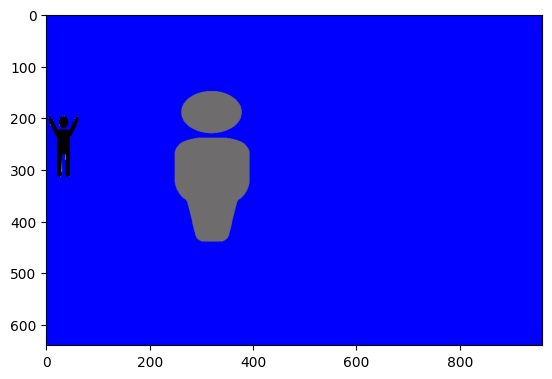

In [ ]:
plt.imshow(X[0])

## prepare data
1. resizes images to SIZExSIZE
2. normalizes images to [0,1]

In [ ]:
X = [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X] 
# greyscale
X = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X]
X = np.array(X)
# normalize
X = X / 255.0

y = y.reshape(-1, 4)

print(X.shape, y.shape)

(137, 96, 96) (137, 4)


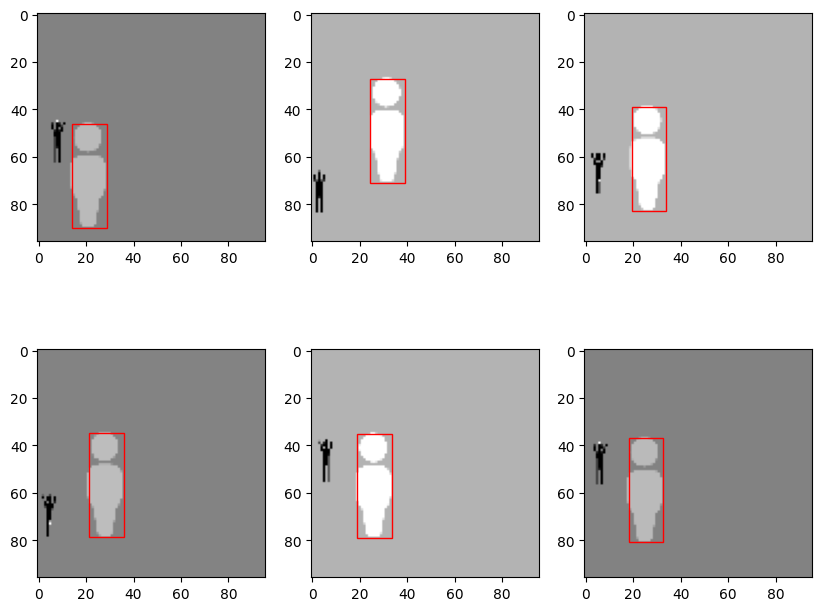

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
images = np.random.choice(X.shape[0], 6)

for i in range(2):
    for j in range(3):
        rect = y[images[i * 3 + j]]
        ax[i, j].imshow(X[images[i * 3 + j]], cmap="gray")
        ax[i, j].add_patch(
            plt.Rectangle(
                (rect[0] * IMG_SIZE, rect[1] * IMG_SIZE),
                rect[2] * IMG_SIZE,
                rect[3] * IMG_SIZE,
                fill=False,
                color="red",
            )
        )

plt.show()